/home/brian/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brian/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda:0


Epoch 1/10, Train: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it, loss=0.947, accuracy=71.4]


Epoch [1/10], Train Loss: 0.9471, Train Accuracy: 71.44%, Val Loss: 1.6818, Val Accuracy: 49.49%


Epoch 2/10, Train: 100%|██████████| 22/22 [00:25<00:00,  1.17s/it, loss=1.09, accuracy=61.3] 


Epoch [2/10], Train Loss: 1.0903, Train Accuracy: 61.29%, Val Loss: 0.6382, Val Accuracy: 87.37%


Epoch 3/10, Train: 100%|██████████| 22/22 [00:24<00:00,  1.14s/it, loss=0.487, accuracy=86.6]


Epoch [3/10], Train Loss: 0.4869, Train Accuracy: 86.63%, Val Loss: 0.3602, Val Accuracy: 87.37%


Epoch 4/10, Train: 100%|██████████| 22/22 [00:26<00:00,  1.19s/it, loss=0.3, accuracy=91]    


Epoch [4/10], Train Loss: 0.3002, Train Accuracy: 91.02%, Val Loss: 0.2414, Val Accuracy: 94.20%


Epoch 5/10, Train: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.183, accuracy=96.6] 


Epoch [5/10], Train Loss: 0.1831, Train Accuracy: 96.64%, Val Loss: 0.1681, Val Accuracy: 93.86%


Epoch 6/10, Train: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, loss=0.124, accuracy=97]   


Epoch [6/10], Train Loss: 0.1237, Train Accuracy: 97.01%, Val Loss: 0.1228, Val Accuracy: 95.90%


Epoch 7/10, Train: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it, loss=0.0878, accuracy=97.5]


Epoch [7/10], Train Loss: 0.0878, Train Accuracy: 97.52%, Val Loss: 0.0963, Val Accuracy: 97.27%


Epoch 8/10, Train: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it, loss=0.0676, accuracy=98]  


Epoch [8/10], Train Loss: 0.0676, Train Accuracy: 97.95%, Val Loss: 0.0806, Val Accuracy: 97.27%


Epoch 9/10, Train: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, loss=0.05, accuracy=98.6]  


Epoch [9/10], Train Loss: 0.0500, Train Accuracy: 98.61%, Val Loss: 0.0687, Val Accuracy: 98.63%


Epoch 10/10, Train: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it, loss=0.0488, accuracy=98.6]


Epoch [10/10], Train Loss: 0.0488, Train Accuracy: 98.61%, Val Loss: 0.0625, Val Accuracy: 98.63%
Test Loss: 0.0179, Test Accuracy: 100.00%


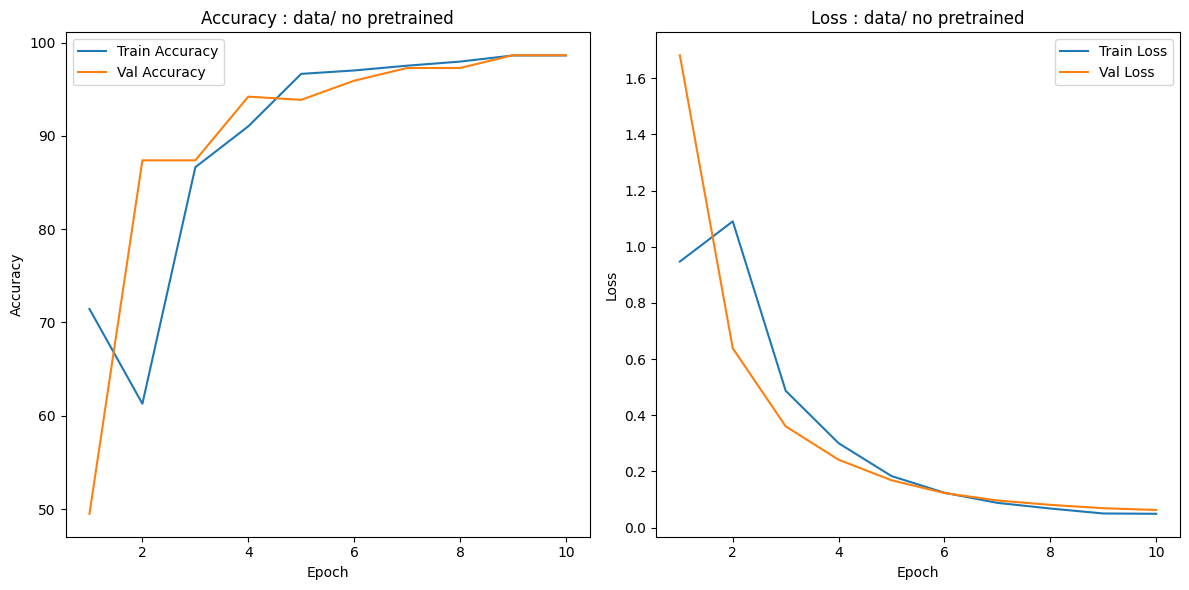

In [22]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# # set data set and pretrained
data_aug = False
pretain_weight = False

if data_aug :
    data_set = 'preprocess_data'
else :
    data_set = 'data'

if pretain_weight :
    pret = '/ pretrained'
else :
    pret = '/ no pretrained'

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected size for ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet's mean and std
])



# Load dataset
# # Original data
dataset = datasets.ImageFolder(root=data_set, transform=transform)
# # Preprocess_data
dataset = datasets.ImageFolder(root=data_set, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

# Load pretrained ResNet18 model
model = models.resnet18(pretrained=pretain_weight)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Modify the final fully connected layer for classification

# Move model to GPU for acceleration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.09)

# Train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}, Train')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'loss': train_loss / len(progress_bar), 'accuracy': 100 * correct / total})

        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_accuracies, val_accuracies, train_losses, val_losses

def evaluate_model(model, criterion, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Train the model and plot accuracies and losses
train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Test the model
test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy : ' + data_set + pret)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss : ' + data_set + pret)
plt.legend()

plt.tight_layout()
plt.show()
